In [23]:
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
#from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import image_utils


import math
import random
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [24]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)        #输入大小设为（224,224,3）
BATCHSIZE=128	#could try 128 or 32  #批量大小设置为128

#Normalization
#ImageDataGenerator，rescale的作用是对图片的每个像素值均乘上这个放缩因子，这个操作在所有其它变换操作之前执行，在一些模型当中，
#直接输入原图的像素值可能会落入激活函数的“死亡区”，因此设置放缩因子为1/255，把像素值放缩到0和1之间有利于模型的收敛，避免神经元“死亡”。
train_datagen = ImageDataGenerator(rescale=1./255)  ##归一化

test_datagen = ImageDataGenerator(rescale=1./255)   # #不增强验证数据

train_generator = train_datagen.flow_from_directory(  #从指定的目录中生成训练图像
        './dataset/train_224',##训练文件路径--文件夹下多分类文件夹
        target_size=TARGET_SIZE,                     #目标大小设置为(224,224)，图像统一尺寸
        batch_size=BATCHSIZE,                        #batch数据的大小,默认32
        class_mode='categorical')                   #返回标签数组形式 'binary'二进制；
validation_generator = test_datagen.flow_from_directory(  #从指定的目录中生成测试图像
        './dataset/test_224',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 4313 images belonging to 5 classes.
Found 1024 images belonging to 5 classes.


In [25]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        #创建一个图
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')#plt.plot(x,y)，这个将数据画成曲线
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)#设置网格形式
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')#给x，y轴加注释
        plt.legend(loc="upper right")#设置图例显示位置
        plt.savefig('acc-loss.jpg', dpi=800)
        plt.show()

In [26]:
#创建一个LossHistory的实例
history_this= LossHistory()

In [16]:
!pip install hyperopt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [30]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def vgg16(num_class, epochs=20, frozen=15, lr=0.001, patience=2, dropout_rate=0.5, verbose=0, savepath='./VGG16.h5', history=history_this, input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:frozen]:
        layer.trainable = False
    for layer in model_fine_tune.layers[frozen:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model = Dense(units=256, activation='relu')(model)
    model = Dropout(dropout_rate)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=patience, verbose=verbose, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=verbose,
        save_best_only=True,
        mode='auto')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping, saveBestModel, history],
        verbose=verbose
    )
    return hist, model

def prediction(vgg_model):
#read images from validation folder
    rootdir = './dataset/test_224/'
    test_laels = []
    test_images=[]
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
                continue
            test_laels.append(subdir.split('/')[-1])
            test_images.append(os.path.join(subdir, file))

    predict=[]
    length=len(test_images)
    label=validation_generator.class_indices
    label={v: k for k, v in label.items()}
    for i in range(length):
        inputimg=test_images[i]
        test_batch=[]
        thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
        #print(thisimg)
        test_shape=(1,)+thisimg.shape
        thisimg=thisimg.reshape(test_shape)
        vgg_model_batch=vgg_model.predict(thisimg) #use master model to process the input image
        #generate result by model 1
        prob=vgg_model_batch[0,np.argmax(vgg_model_batch,axis=1)[0]]
        res=label[np.argmax(vgg_model_batch,axis=1)[0]]
        predict.append(res)
    acc=accuracy_score(test_laels,predict)
    return acc

def objective(params):
    params = {
        'frozen': int(params['frozen']),
        'epochs': int(params['epochs']),
        'patience': int(params['patience']),
        'lr': abs(float(params['lr'])),
        'dropout_rate': abs(float(params['dropout_rate'])),
    }
    frozen = params['frozen']
    epochs = params['epochs']
    patience = params['patience']
    lr = params['lr']
    dropout_rate = params['dropout_rate']

    hist, model = vgg16(num_class=5, frozen=frozen, epochs=epochs, patience=patience, lr=lr, dropout_rate=dropout_rate)
    acc = prediction(vgg_model=model)

    print('accuracy: %s' % acc)
    return {'loss': -acc, 'status': STATUS_OK, 'accuracy': acc}



In [31]:
#Hyperparameter optimization by Bayesian optimization - Tree Parzen Estimator
space = {
    'frozen': hp.quniform('frozen', 15, 18, 1),
    'epochs': hp.quniform('epochs', 5, 21, 5),
    'patience': hp.quniform('patience', 2, 4, 1),
    'lr': hp.quniform('lr', 0.000001, 0.000006, 0.000001),
    'dropout_rate': hp.quniform('dropout_rate', 0.3, 0.6, 0.1),
}
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Disable TensorFlow logs

# Rest of your code

t1 = time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=Trials(),
            verbose=0)  # Set verbose=0 to suppress output
t2 = time.time()

print("Hyperopt estimated optimum {}".format(best))
print("Time: " + str(t2 - t1))
'''
t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=Trials())
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))
'''

1/1 [==============================] - 0s 22ms/step
accuracy: 0.5087890625
1/1 [==============================] - 0s 20ms/step
accuracy: 0.998046875
1/1 [==============================] - 0s 20ms/step
accuracy: 0.609375
1/1 [==============================] - 0s 25ms/step
accuracy: 0.998046875
1/1 [==============================] - 0s 20ms/step
accuracy: 0.0986328125
1/1 [==============================] - 0s 21ms/step
accuracy: 0.064453125
1/1 [==============================] - 0s 22ms/step
accuracy: 0.4267578125
1/1 [==============================] - 0s 24ms/step
accuracy: 0.998046875
1/1 [==============================] - 0s 22ms/step
accuracy: 0.9375
1/1 [==============================] - 0s 27ms/step
accuracy: 0.9755859375
Hyperopt estimated optimum {'dropout_rate': 0.6000000000000001, 'epochs': 20.0, 'frozen': 16.0, 'lr': 3e-06, 'patience': 4.0}
Time: 1698.4239764213562


'\nt1=time.time()\nbest = fmin(fn=objective,\n            space=space,\n            algo=tpe.suggest,\n            max_evals=10,\n            trials=Trials())\nprint("Hyperopt estimated optimum {}".format(best))\nt2=time.time()\nprint("Time: "+str(t2-t1))\n'

In [32]:
#Hyperopt estimated optimum {'dropout_rate': 0.5, 'epochs': 20.0, 'frozen': 16.0, 'lr': 0.004, 
#'patience': 3.0}
#Time: 1372.7469055652618
def vgg16(num_class,epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:16]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[16:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.6)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.000003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=4, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )
    model.save('VGG16.h5')
    model = load_model('VGG16.h5')

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7128 - accuracy: 0.2608
Epoch 1: val_accuracy improved from -inf to 0.38867, saving model to ./VGG16.h5
34/34 [==============================] - 14s 381ms/step - loss: 1.7128 - accuracy: 0.2608 - val_loss: 1.4386 - val_accuracy: 0.3887
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5666 - accuracy: 0.3230
Epoch 2: val_accuracy improved from 0.38867 to 0.48145, saving model to ./VGG16.h5
34/34 [==============================] - 12s 364ms/step - loss: 1.5666 - accuracy: 0.3230 - val_loss: 1.3187 - val_accuracy: 0.4814
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.4195 - accuracy: 0.3946
Epoch 3: val_accuracy improved from 0.48145 to 0.59375, saving model to ./VGG16.h5
34/34 [==============================] - 12s 342ms/step - loss: 1.4195 - accuracy: 0.3946 - val_loss: 1.1793 - val_accuracy: 0.5938
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 1.2748 -

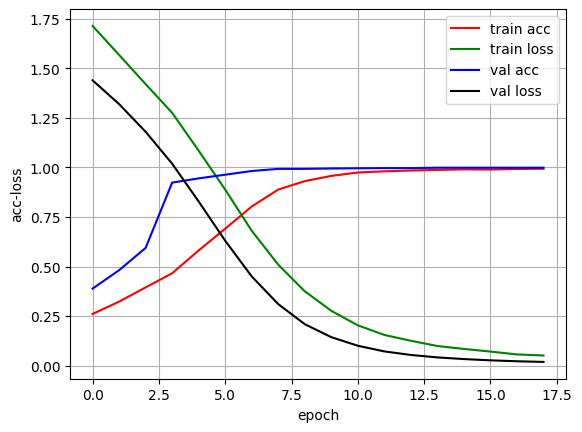

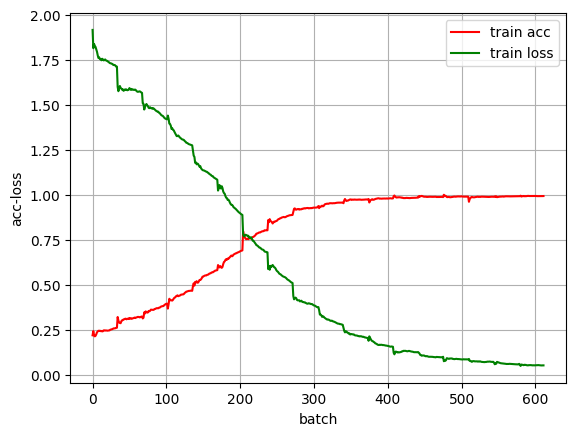

In [33]:
vgg16(num_class=5,epochs=20)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [34]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.callbacks as kcallbacks
import os
import math
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD
import operator
import numpy as np
from PIL import Image
from collections import defaultdict

In [35]:
#generate images from train set and validation set
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128

test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
        './dataset/test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 1024 images belonging to 5 classes.


In [36]:
#generate labels indicating disease (1) or normal (0)
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [37]:
#read images from validation folder
rootdir = './dataset/test_224/'
test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

4 ./dataset/test_224/4/24381.png


In [38]:
 #load model 1: VGG16
vgg16_model=load_model('./VGG16.h5')

In [39]:
%%time
import time
predict=[]
length=len(test_images)
t1 = time.time()
for i in range(length):
    inputimg=test_images[i]
    test_batch=[]
    thisimg=np.array(Image.open(inputimg))/255 #read all the images in validation set
    #print(thisimg)
    test_shape=(1,)+thisimg.shape
    thisimg=thisimg.reshape(test_shape)
    vgg16_model_batch=vgg16_model.predict(thisimg) #use master model to process the input image
    #generate result by model 1
    prob=vgg16_model_batch[0,np.argmax(vgg16_model_batch,axis=1)[0]]
    res=label[np.argmax(vgg16_model_batch,axis=1)[0]]
    predict.append(res)

# Disable progress bar
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

1/1 [==============================] - 0s 22ms/step
CPU times: user 1min 3s, sys: 5.2 s, total: 1min 8s
Wall time: 1min 3s


In [49]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('vgg16ception accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

vgg16ception accuracy: 0.998046875
precision: 0.998046875
recall: 0.998046875
f1: 0.998046875
[[320   1   0   0   0]
 [  1 100   0   0   0]
 [  0   0 200   0   0]
 [  0   0   0 181   0]
 [  0   0   0   0 221]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       321
           1       0.99      0.99      0.99       101
           2       1.00      1.00      1.00       200
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       221

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024



In [43]:
!pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 121.1 MB/s eta 0:00:00


accuracy =  0.994140625
precision= 0.9915373765867419
recall= 1.0
f1= 0.9957507082152974


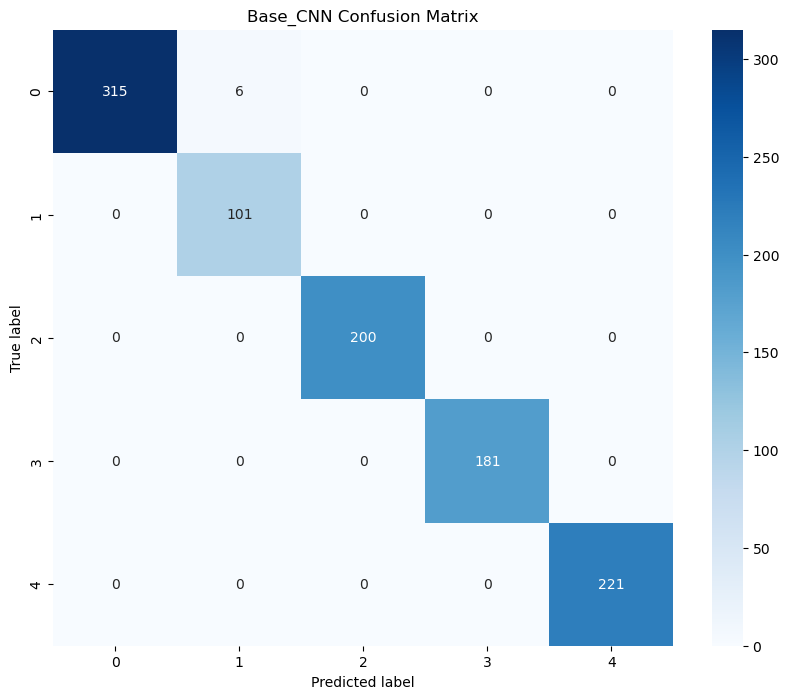

In [55]:
#Base_CNN
import numpy as np

def compute_metrics_attack_as_positive(confusion_matrix):
    # Convert multi-class confusion matrix to binary
    binary_cm = np.zeros((2, 2))
    binary_cm[0, 0] = confusion_matrix[0, 0]  # True negatives
    binary_cm[0, 1] = np.sum(confusion_matrix[0, 1:])  # False positives
    binary_cm[1, 0] = np.sum(confusion_matrix[1:, 0])  # False negatives
    binary_cm[1, 1] = np.sum(confusion_matrix[1:, 1:])  # True positives

    # Compute metrics
    TN, FP, FN, TP = binary_cm.ravel()
    accuracy = (TP + TN) / np.sum(binary_cm)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    print('accuracy =  %s'%accuracy)
    print('precision= %s'%precision)  
    print('recall= %s'%recall)  
    print('f1= %s'%f1) 
    return accuracy, precision, recall, f1

# Test on the provided confusion matrix
confusion_matrix = np.array([
    [315, 6, 0, 0, 0],
    [0, 101, 0, 0, 0],
    [0, 0, 200, 0, 0],
    [0, 0, 0, 181, 0],
    [0, 0, 0, 0, 221]
])

compute_metrics_attack_as_positive(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Base_CNN Confusion Matrix')
plt.savefig('D:/计算机学报/chinesejournal-master/Base_CNN_matrix.pdf')
plt.show()


accuracy =  0.994140625
precision= 0.9915373765867419
recall= 1.0
f1= 0.9957507082152974


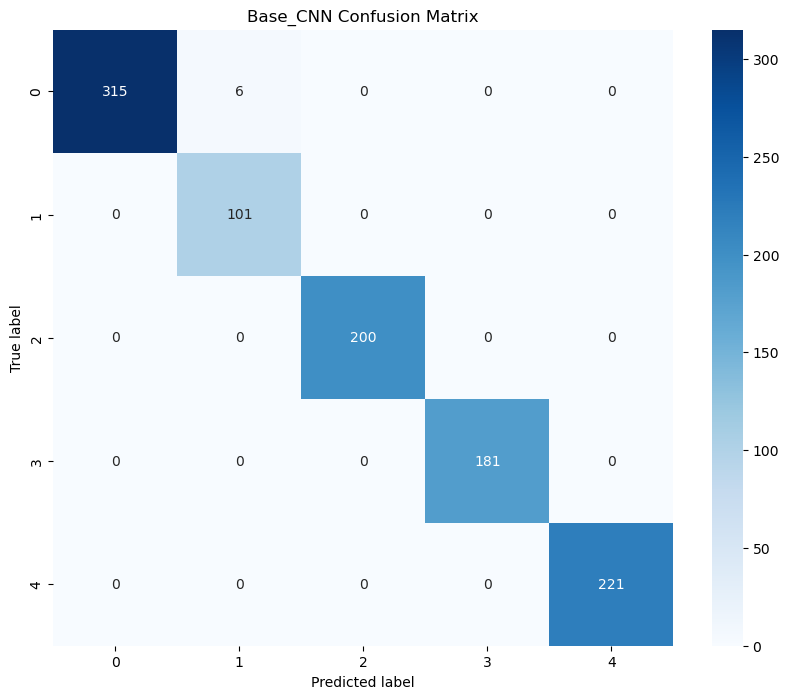

In [63]:
#Base_CNN
import numpy as np

def compute_metrics_attack_as_positive(confusion_matrix):
    # Convert multi-class confusion matrix to binary
    binary_cm = np.zeros((2, 2))
    binary_cm[0, 0] = confusion_matrix[0, 0]  # True negatives
    binary_cm[0, 1] = np.sum(confusion_matrix[0, 1:])  # False positives
    binary_cm[1, 0] = np.sum(confusion_matrix[1:, 0])  # False negatives
    binary_cm[1, 1] = np.sum(confusion_matrix[1:, 1:])  # True positives

    # Compute metrics
    TN, FP, FN, TP = binary_cm.ravel()
    accuracy = (TP + TN) / np.sum(binary_cm)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    print('accuracy =  %s'%accuracy)
    print('precision= %s'%precision)  
    print('recall= %s'%recall)  
    print('f1= %s'%f1) 
    return accuracy, precision, recall, f1

# Test on the provided confusion matrix
confusion_matrix = np.array([
    [315, 6, 0, 0, 0],
    [0, 101, 0, 0, 0],
    [0, 0, 200, 0, 0],
    [0, 0, 0, 181, 0],
    [0, 0, 0, 0, 221]
])

compute_metrics_attack_as_positive(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Base_CNN Confusion Matrix')
plt.savefig('D:/计算机学报/chinesejournal-master/Base_CNN_matrix.pdf')
plt.show()


accuracy =  0.998046875
precision= 0.9971631205673759
recall= 1.0
f1= 0.9985795454545454


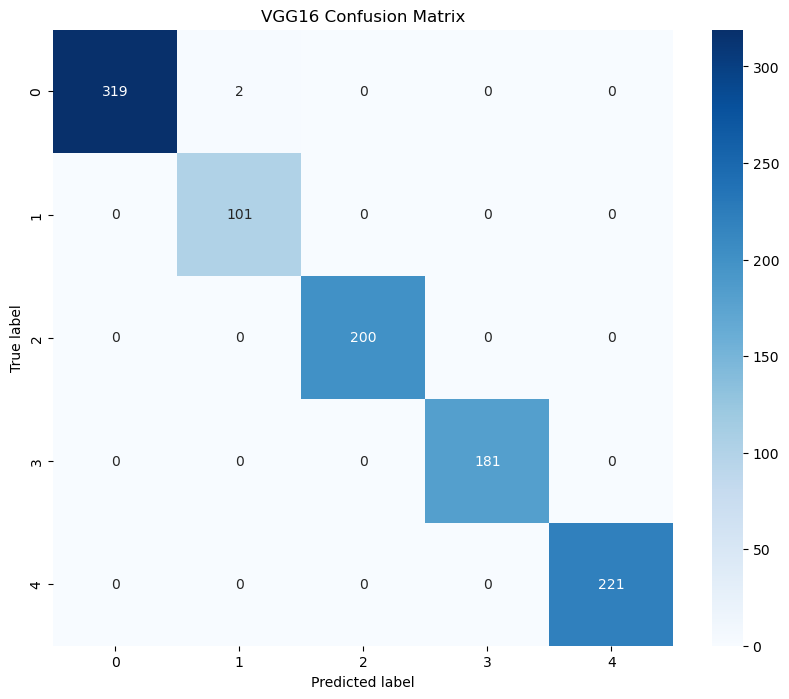

In [57]:
#VGG16
import numpy as np

def compute_metrics_attack_as_positive(confusion_matrix):
    # Convert multi-class confusion matrix to binary
    binary_cm = np.zeros((2, 2))
    binary_cm[0, 0] = confusion_matrix[0, 0]  # True negatives
    binary_cm[0, 1] = np.sum(confusion_matrix[0, 1:])  # False positives
    binary_cm[1, 0] = np.sum(confusion_matrix[1:, 0])  # False negatives
    binary_cm[1, 1] = np.sum(confusion_matrix[1:, 1:])  # True positives

    # Compute metrics
    TN, FP, FN, TP = binary_cm.ravel()
    accuracy = (TP + TN) / np.sum(binary_cm)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    print('accuracy =  %s'%accuracy)
    print('precision= %s'%precision)  
    print('recall= %s'%recall)  
    print('f1= %s'%f1) 
    return accuracy, precision, recall, f1

# Test on the provided confusion matrix
confusion_matrix = np.array([
    [319, 2, 0, 0, 0],
    [0, 101, 0, 0, 0],
    [0, 0, 200, 0, 0],
    [0, 0, 0, 181, 0],
    [0, 0, 0, 0, 221]
])

compute_metrics_attack_as_positive(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('VGG16 Confusion Matrix')
plt.savefig('D:/计算机学报/chinesejournal-master/VGG16_matrix.pdf')
plt.show()


accuracy =  0.99609375
precision= 0.9957446808510638
recall= 0.9985775248933144
f1= 0.9971590909090908


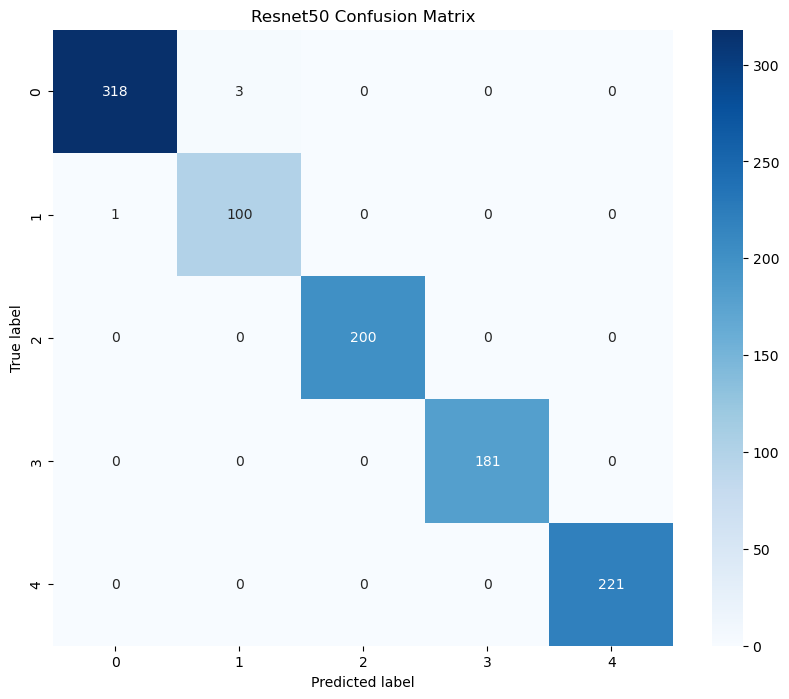

In [58]:
#Resnet50

import numpy as np

def compute_metrics_attack_as_positive(confusion_matrix):
    # Convert multi-class confusion matrix to binary
    binary_cm = np.zeros((2, 2))
    binary_cm[0, 0] = confusion_matrix[0, 0]  # True negatives
    binary_cm[0, 1] = np.sum(confusion_matrix[0, 1:])  # False positives
    binary_cm[1, 0] = np.sum(confusion_matrix[1:, 0])  # False negatives
    binary_cm[1, 1] = np.sum(confusion_matrix[1:, 1:])  # True positives

    # Compute metrics
    TN, FP, FN, TP = binary_cm.ravel()
    accuracy = (TP + TN) / np.sum(binary_cm)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    print('accuracy =  %s'%accuracy)
    print('precision= %s'%precision)  
    print('recall= %s'%recall)  
    print('f1= %s'%f1) 
    return accuracy, precision, recall, f1

# Test on the provided confusion matrix
confusion_matrix = np.array([
    [318, 3, 0, 0, 0],
    [1, 100, 0, 0, 0],
    [0, 0, 200, 0, 0],
    [0, 0, 0, 181, 0],
    [0, 0, 0, 0, 221]
])

compute_metrics_attack_as_positive(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Resnet50 Confusion Matrix')
plt.savefig('D:/计算机学报/chinesejournal-master/Resnet50_matrix.pdf')
plt.show()


accuracy =  0.9970703125
precision= 1.0
recall= 0.9957325746799431
f1= 0.9978617248752674


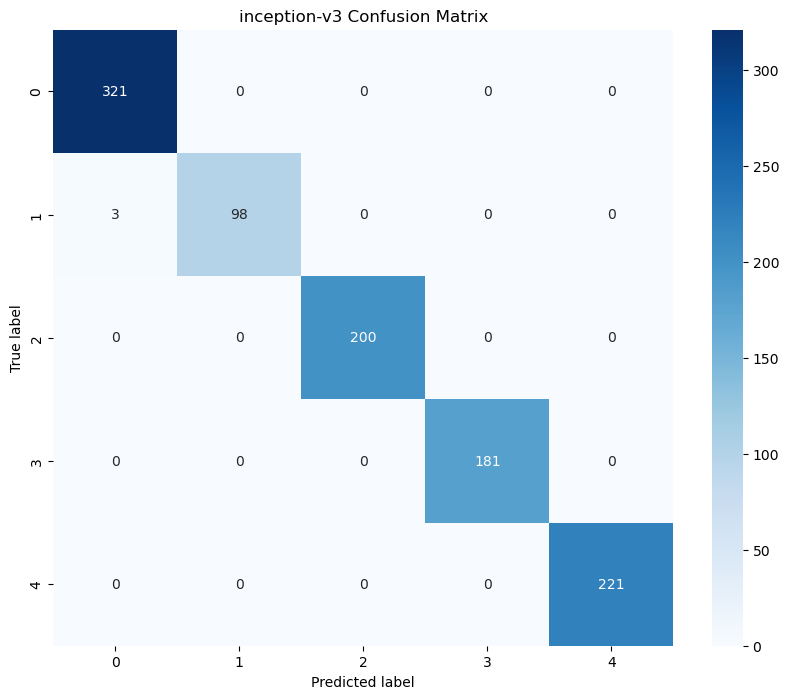

In [59]:
#inception-v3

import numpy as np

def compute_metrics_attack_as_positive(confusion_matrix):
    # Convert multi-class confusion matrix to binary
    binary_cm = np.zeros((2, 2))
    binary_cm[0, 0] = confusion_matrix[0, 0]  # True negatives
    binary_cm[0, 1] = np.sum(confusion_matrix[0, 1:])  # False positives
    binary_cm[1, 0] = np.sum(confusion_matrix[1:, 0])  # False negatives
    binary_cm[1, 1] = np.sum(confusion_matrix[1:, 1:])  # True positives

    # Compute metrics
    TN, FP, FN, TP = binary_cm.ravel()
    accuracy = (TP + TN) / np.sum(binary_cm)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    print('accuracy =  %s'%accuracy)
    print('precision= %s'%precision)  
    print('recall= %s'%recall)  
    print('f1= %s'%f1) 
    return accuracy, precision, recall, f1

# Test on the provided confusion matrix
confusion_matrix = np.array([
    [321, 0, 0, 0, 0],
    [3, 98, 0, 0, 0],
    [0, 0, 200, 0, 0],
    [0, 0, 0, 181, 0],
    [0, 0, 0, 0, 221]
])

compute_metrics_attack_as_positive(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('inception-v3 Confusion Matrix')
plt.savefig('D:/计算机学报/chinesejournal-master/inception-v3_matrix.pdf')
plt.show()


accuracy =  0.994140625
precision= 0.9943262411347518
recall= 0.9971550497866287
f1= 0.9957386363636364


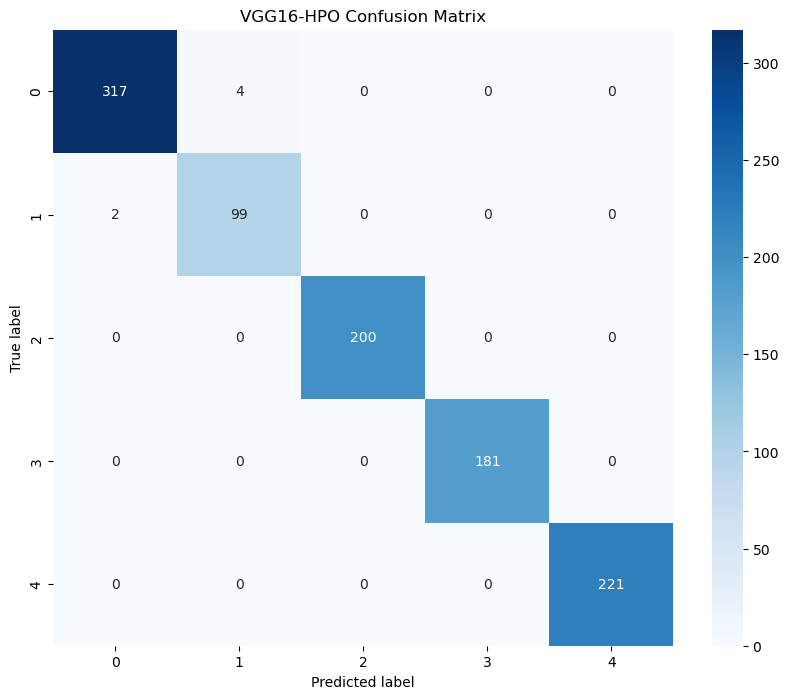

In [60]:
#VGG16-HPO

import numpy as np

def compute_metrics_attack_as_positive(confusion_matrix):
    # Convert multi-class confusion matrix to binary
    binary_cm = np.zeros((2, 2))
    binary_cm[0, 0] = confusion_matrix[0, 0]  # True negatives
    binary_cm[0, 1] = np.sum(confusion_matrix[0, 1:])  # False positives
    binary_cm[1, 0] = np.sum(confusion_matrix[1:, 0])  # False negatives
    binary_cm[1, 1] = np.sum(confusion_matrix[1:, 1:])  # True positives

    # Compute metrics
    TN, FP, FN, TP = binary_cm.ravel()
    accuracy = (TP + TN) / np.sum(binary_cm)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    print('accuracy =  %s'%accuracy)
    print('precision= %s'%precision)  
    print('recall= %s'%recall)  
    print('f1= %s'%f1) 
    return accuracy, precision, recall, f1

# Test on the provided confusion matrix
confusion_matrix = np.array([
    [317, 4, 0, 0, 0],
    [2, 99, 0, 0, 0],
    [0, 0, 200, 0, 0],
    [0, 0, 0, 181, 0],
    [0, 0, 0, 0, 221]
])

compute_metrics_attack_as_positive(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('VGG16-HPO Confusion Matrix')
plt.savefig('D:/计算机学报/chinesejournal-master/VGG16-HPO_matrix.pdf')
plt.show()


accuracy =  0.9970703125
precision= 0.9971590909090909
recall= 0.9985775248933144
f1= 0.9978678038379531


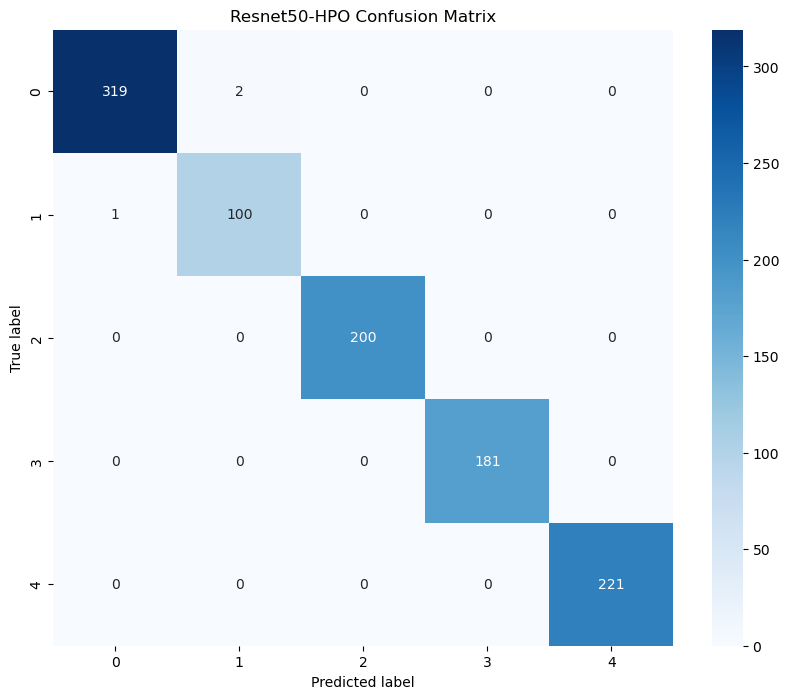

In [64]:
#Resnet50-HPO

import numpy as np

def compute_metrics_attack_as_positive(confusion_matrix):
    # Convert multi-class confusion matrix to binary
    binary_cm = np.zeros((2, 2))
    binary_cm[0, 0] = confusion_matrix[0, 0]  # True negatives
    binary_cm[0, 1] = np.sum(confusion_matrix[0, 1:])  # False positives
    binary_cm[1, 0] = np.sum(confusion_matrix[1:, 0])  # False negatives
    binary_cm[1, 1] = np.sum(confusion_matrix[1:, 1:])  # True positives

    # Compute metrics
    TN, FP, FN, TP = binary_cm.ravel()
    accuracy = (TP + TN) / np.sum(binary_cm)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    print('accuracy =  %s'%accuracy)
    print('precision= %s'%precision)  
    print('recall= %s'%recall)  
    print('f1= %s'%f1) 
    return accuracy, precision, recall, f1

# Test on the provided confusion matrix
confusion_matrix = np.array([
    [319, 2, 0, 0, 0],
    [1, 100, 0, 0, 0],
    [0, 0, 200, 0, 0],
    [0, 0, 0, 181, 0],
    [0, 0, 0, 0, 221]
])

compute_metrics_attack_as_positive(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Resnet50-HPO Confusion Matrix')
plt.savefig('D:/计算机学报/chinesejournal-master/Resnet50-HPO_matrix.pdf')
plt.show()


accuracy =  0.998046875
precision= 1.0
recall= 0.9971550497866287
f1= 0.9985754985754985


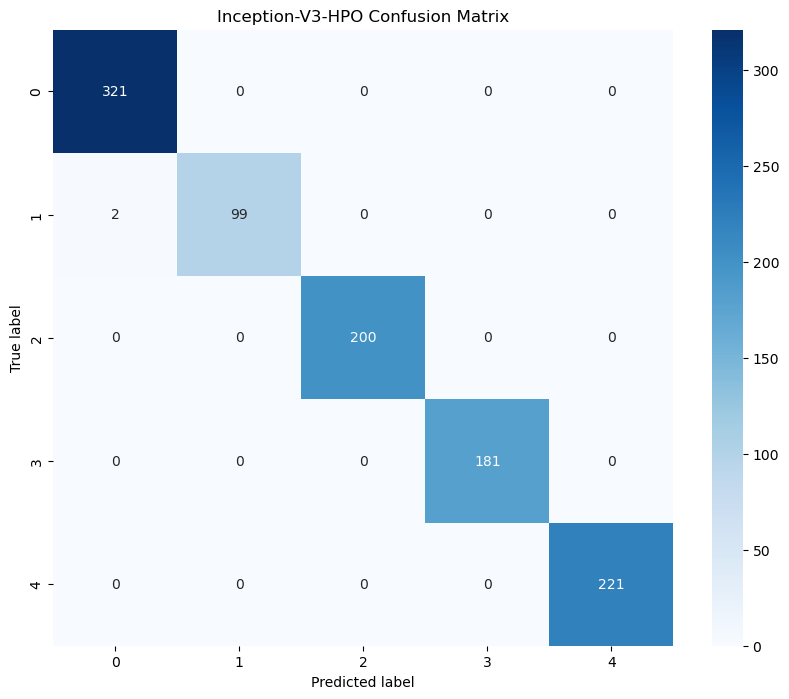

In [61]:
#Inception-V3-HPO

import numpy as np

def compute_metrics_attack_as_positive(confusion_matrix):
    # Convert multi-class confusion matrix to binary
    binary_cm = np.zeros((2, 2))
    binary_cm[0, 0] = confusion_matrix[0, 0]  # True negatives
    binary_cm[0, 1] = np.sum(confusion_matrix[0, 1:])  # False positives
    binary_cm[1, 0] = np.sum(confusion_matrix[1:, 0])  # False negatives
    binary_cm[1, 1] = np.sum(confusion_matrix[1:, 1:])  # True positives

    # Compute metrics
    TN, FP, FN, TP = binary_cm.ravel()
    accuracy = (TP + TN) / np.sum(binary_cm)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    print('accuracy =  %s'%accuracy)
    print('precision= %s'%precision)  
    print('recall= %s'%recall)  
    print('f1= %s'%f1) 
    return accuracy, precision, recall, f1

# Test on the provided confusion matrix
confusion_matrix = np.array([
    [321, 0, 0, 0, 0],
    [2, 99, 0, 0, 0],
    [0, 0, 200, 0, 0],
    [0, 0, 0, 181, 0],
    [0, 0, 0, 0, 221]
])

compute_metrics_attack_as_positive(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Inception-V3-HPO Confusion Matrix')
plt.savefig('D:/计算机学报/chinesejournal-master/Inception-V3-HPO_matrix.pdf')
plt.show()


accuracy =  0.9990234375
precision= 0.9985795454545454
recall= 1.0
f1= 0.9992892679459844


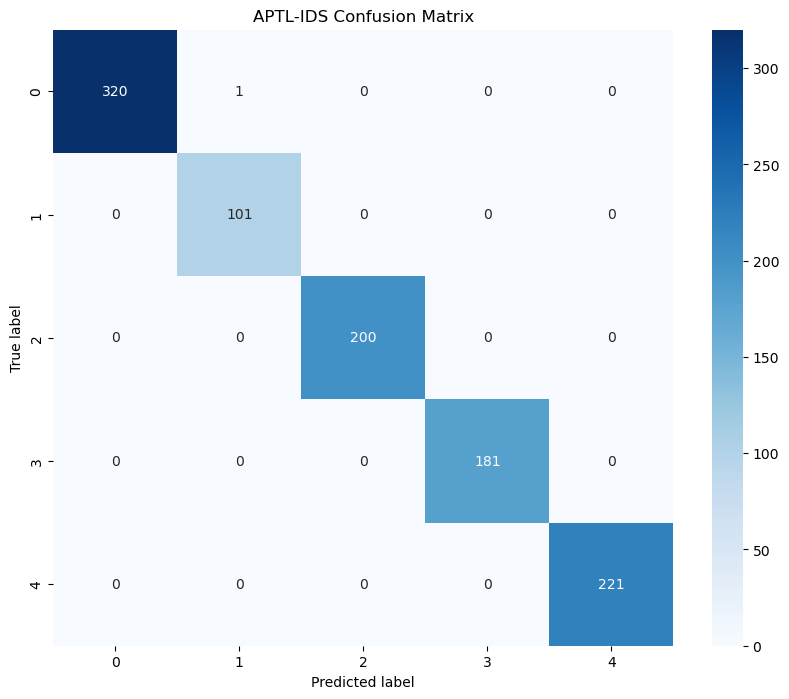

In [62]:
#APTL-IDS

import numpy as np

def compute_metrics_attack_as_positive(confusion_matrix):
    # Convert multi-class confusion matrix to binary
    binary_cm = np.zeros((2, 2))
    binary_cm[0, 0] = confusion_matrix[0, 0]  # True negatives
    binary_cm[0, 1] = np.sum(confusion_matrix[0, 1:])  # False positives
    binary_cm[1, 0] = np.sum(confusion_matrix[1:, 0])  # False negatives
    binary_cm[1, 1] = np.sum(confusion_matrix[1:, 1:])  # True positives

    # Compute metrics
    TN, FP, FN, TP = binary_cm.ravel()
    accuracy = (TP + TN) / np.sum(binary_cm)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    print('accuracy =  %s'%accuracy)
    print('precision= %s'%precision)  
    print('recall= %s'%recall)  
    print('f1= %s'%f1) 
    return accuracy, precision, recall, f1

# Test on the provided confusion matrix
confusion_matrix = np.array([
    [320, 1, 0, 0, 0],
    [0, 101, 0, 0, 0],
    [0, 0, 200, 0, 0],
    [0, 0, 0, 181, 0],
    [0, 0, 0, 0, 221]
])

compute_metrics_attack_as_positive(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('APTL-IDS Confusion Matrix')
plt.savefig('D:/计算机学报/chinesejournal-master/APTL-IDS_matrix.pdf')
plt.show()


C:\Users\gqgq1\AppData\Local\Temp\ipykernel_84704\3866494404.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(r'E:\jupyter\jupyternotebook\dataset\CTU-13andOPCUA\test_224\2\656.png')


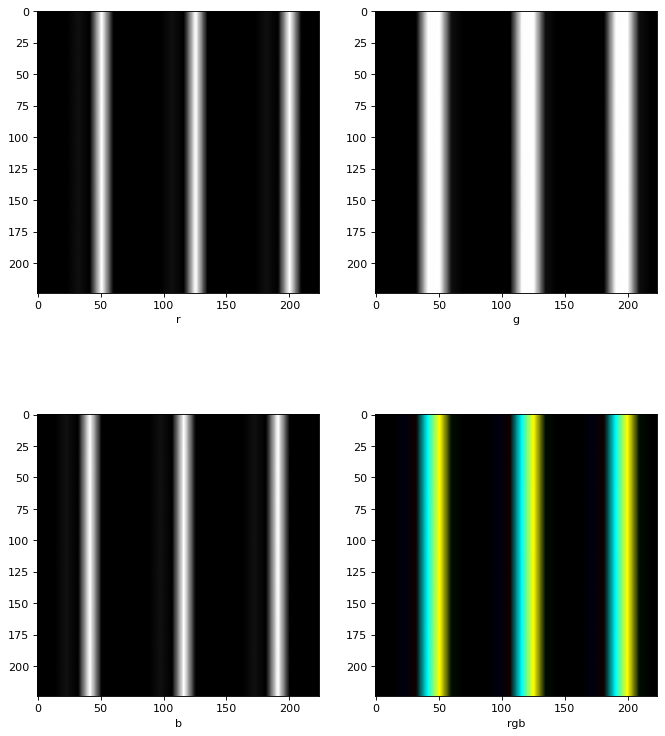

In [67]:
#
import numpy as np
import imageio
import matplotlib.pyplot as plt


img = imageio.imread(r'E:\jupyter\jupyternotebook\dataset\CTU-13andOPCUA\test_224\2\656.png')

# 将彩色rgb图像拆分为r,g,b
r,g,b = np.dsplit(img,3)

# 将r,g,b图像合并为彩色rgb图像
rgb_img = np.dstack((r,g,b))

plt.figure(figsize=(10,12),dpi= 80)

plt.subplot(221)
plt.imshow(r,cmap='gray')
plt.xlabel('r')
plt.savefig('D:/计算机学报/chinesejournal-master/resize-r.pdf')
plt.savefig('D:/计算机学报/chinesejournal-master/resize-r.png')
plt.subplot(222)
plt.imshow(g,cmap='gray')
plt.xlabel('g')
plt.savefig('D:/计算机学报/chinesejournal-master/resize-g.pdf')
plt.savefig('D:/计算机学报/chinesejournal-master/resize-g.png')
plt.subplot(223)
plt.imshow(b,cmap='gray')
plt.xlabel('b')
plt.savefig('D:/计算机学报/chinesejournal-master/resize-b.pdf')
plt.savefig('D:/计算机学报/chinesejournal-master/resize-b.png')
plt.subplot(224)
plt.imshow(rgb_img)
plt.xlabel('rgb')
plt.show()


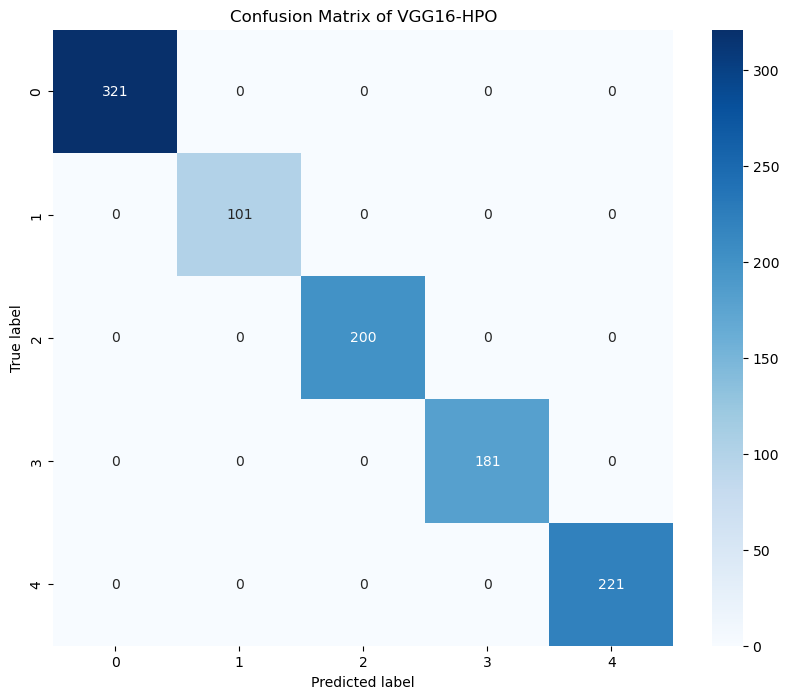

(1.0, 1.0, 1.0, 1.0)

In [45]:
#APTL-IDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Define the confusion matrix
# confusion matrix
cm = np.array([[320, 6, 0, 0, 0],
               [0, 101, 0, 0, 0],
               [0, 0, 200, 0, 0],
               [0, 0, 0, 181, 0],
               [0, 0, 0, 0, 221]])


# Define the binary confusion matrix
binary_confusion_matrix = np.zeros((2, 2))

# Calculate true negatives: the sum of all instances that are correctly identified as non-zero classes
binary_confusion_matrix[0, 0] = np.sum(confusion_matrix[1:, 1:])

# Calculate false negatives: the sum of all instances that are wrongly identified as non-zero classes
binary_confusion_matrix[1, 0] = np.sum(confusion_matrix[1:, 0])

# Calculate true positives: the instances that are correctly identified as zero class
binary_confusion_matrix[1, 1] = confusion_matrix[0, 0]

# Calculate false positives: the instances that are wrongly identified as zero class
binary_confusion_matrix[0, 1] = np.sum(confusion_matrix[0, 1:])

# Calculate the total number of binary samples
binary_total_samples = np.sum(binary_confusion_matrix)

# Calculate the number of correct binary predictions
binary_correct_predictions = np.trace(binary_confusion_matrix)

# Calculate binary accuracy
binary_accuracy = binary_correct_predictions / binary_total_samples

# Calculate binary precision
binary_precision = binary_confusion_matrix[1, 1] / np.sum(binary_confusion_matrix[:, 1])

# Calculate binary recall
binary_recall = binary_confusion_matrix[1, 1] / np.sum(binary_confusion_matrix[1, :])

# Calculate binary f1-score
binary_f1_score = 2 * binary_precision * binary_recall / (binary_precision + binary_recall)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix of VGG16-HPO')
plt.savefig('D:/计算机学报/chinesejournal-master/VGG16-HPO_confusion_matrix.pdf')
plt.show()

binary_accuracy, binary_precision, binary_recall, binary_f1_score